In [1]:
import pandas as pd
import numpy as np
import sqlite3
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from model import get_optimized_parameters, test_model, invPred, create_study, calculate_RV

2023-11-27 01:54:34.146964: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/miniconda3/envs/fintech/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
timeline = pd.read_csv('./crypto_reg_timeline.csv')
timeline['Date'] = pd.to_datetime(timeline['Date'], format='%Y%m%d')

In [3]:
timeline.tail()

,Date,Country/Region,Topic
19,2022-11-02,SP,First DeFi trades in wholesale markets of gove...
20,2022-12-16,Global,BCBS final standard on prudential treatment fo...
21,2023-01-27,US,FED wants to limit activitiy of SMBs from hold...
22,2023-03-12,US,SVB and Signature Bank crash
23,2023-06-29,EU,EU Parliament issued MiCAr legislation on cryp...


In [4]:
tweets = pd.read_csv('Bitcoin_tweets_dataset_2.csv', lineterminator='\n')
tweets.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ChefSam,Sunshine State,Culinarian | Hot Sauce Artisan | Kombucha Brew...,2011-03-23 03:50:13,4680,2643,6232,False,2023-03-01 23:59:59,Which #bitcoin books should I think about read...,['bitcoin'],Twitter for iPhone,False
1,Roy⚡️,NaN,Truth-seeking pleb 📚 • Science 🧪 • Nature 🌱☀️ ...,2022-01-30 17:41:41,770,1145,9166,False,2023-03-01 23:59:47,"@ThankGodForBTC I appreciate the message, but ...",['Bitcoin'],Twitter for iPhone,False
2,Ethereum Yoda,NaN,UP or DOWN...\n.\n.\n.\n.\nPrice matters NOT.,2022-07-24 04:50:18,576,1,0,False,2023-03-01 23:59:42,#Ethereum price update: \n\n#ETH $1664.02 USD\...,"['Ethereum', 'ETH', 'Bitcoin', 'BTC', 'altcoin...",Twitter Web App,False
3,Viction,"Paris, France",https://t.co/8M3rgdjwEe\n\n#bitcoin #blockchai...,2010-03-26 10:15:26,236,1829,2195,False,2023-03-01 23:59:36,CoinDashboard v3.0 is here\nAvailable on ios a...,['Bitcoin'],Twitter for Android,False
4,Rosie,London,"The flower language of jasmine is loyalty, res...",2013-02-16 09:57:56,12731,46,134,False,2023-03-01 23:59:32,#Bitcoin Short Term Fractal (4H)💥\n\nIn lower ...,"['Bitcoin', 'BTC']",Twitter Web App,False


In [5]:
# tweets['date'] = tweets['date'].str[:10]
tweets['date'] = pd.to_datetime(tweets['date'], format='%Y-%m-%d %H:%M:%S')
tweets.sort_values(by='date', ascending=False, inplace=True)
# tweets.rename(columns={'date': 'Date'}, inplace=True)

# merged_df = pd.merge(timeline, tweets, on='Date', how='inner')

In [6]:
#sentiment analysis for postive or negative
nltk.download('vader_lexicon')

def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment = analyzer.polarity_scores(text)
    return sentiment['compound']
    
tweets['sentiment_score'] = tweets['text'].apply(get_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/MicheleOrlandi/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
tweets_clean = tweets.groupby(pd.Grouper(key='date', freq='15min')).agg({'sentiment_score': 'mean'}).reset_index()
tweets_clean['date'] = pd.to_datetime(tweets_clean['date'], format='%Y-%m-%d %H:%M:%S')

In [8]:
tweets_clean.head()

,date,sentiment_score
0,2023-02-25 20:45:00,0.172491
1,2023-02-25 21:00:00,0.140640
2,2023-02-25 21:15:00,0.093906
3,2023-02-25 21:30:00,0.133207
4,2023-02-25 21:45:00,0.145924


In [9]:
engine = sqlite3.connect('./btc-data.db')
btc = pd.read_sql('SELECT * FROM BTCUSD', engine)

In [10]:
btc.head()

,date,open,high,low,close,volume,transactions,log,logRet
0,2020-01-01 00:15:00,7182.78,7198.400000,7151.60,7157.00,225.209649,790,8.875846,-0.000172
1,2020-01-01 00:30:00,7194.20,7200.004497,7155.00,7155.72,84.017938,617,8.875667,-0.000179
2,2020-01-01 00:45:00,7158.20,7201.900000,7149.25,7155.70,187.857548,809,8.875665,-0.000003
3,2020-01-01 01:00:00,7150.65,7206.100000,7147.18,7167.34,336.479456,729,8.877290,0.001625
4,2020-01-01 01:15:00,7192.40,7226.100000,7163.92,7186.60,410.926622,968,8.879973,0.002684


In [11]:
btc_clean = btc.loc[:, ['date', 'logRet']].copy()
btc_clean['date'] = pd.to_datetime(btc_clean['date'], format='%Y-%m-%d %H:%M:%S')
merged = btc_clean.merge(tweets_clean, on='date', how='inner')

In [26]:
merged.dropna(axis=0, inplace=True)

In [192]:
merged.to_csv('./sentiment.csv', index=False)

In [2]:
merged = pd.read_csv('./sentiment.csv')

In [3]:
study = create_study()

/opt/miniconda3/envs/fintech/lib/python3.10/site-packages/optuna/samplers/_tpe/sampler.py:295: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2023-11-27 01:54:41,324] A new study created in RDB with name: no-name-197127dc-3b09-429e-921b-670aaff7a8ec


Epoch 1/15


/Users/MicheleOrlandi/Desktop/MGT8803/crypto-sentiment-analysis/model.py:101: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_units = trial.suggest_uniform("dropout", 0, 0.5)


17/17 [==============================] - 3s 39ms/step - loss: 7.4816 - mape: 0.8240 - val_loss: 7.1911 - val_mape: 0.8287
Epoch 2/15
17/17 [==============================] - 0s 8ms/step - loss: 7.3600 - mape: 0.8248 - val_loss: 7.0798 - val_mape: 0.8307
Epoch 3/15
17/17 [==============================] - 0s 8ms/step - loss: 7.2211 - mape: 0.8284 - val_loss: 6.9700 - val_mape: 0.8323
Epoch 4/15
17/17 [==============================] - 0s 8ms/step - loss: 7.1120 - mape: 0.8327 - val_loss: 6.8617 - val_mape: 0.8334
Epoch 5/15
17/17 [==============================] - 0s 8ms/step - loss: 6.9844 - mape: 0.8299 - val_loss: 6.7517 - val_mape: 0.8342
Epoch 6/15
17/17 [==============================] - 0s 8ms/step - loss: 6.8726 - mape: 0.8309 - val_loss: 6.6415 - val_mape: 0.8346
Epoch 7/15
17/17 [==============================] - 0s 8ms/step - loss: 6.7529 - mape: 0.8321 - val_loss: 6.5306 - val_mape: 0.8345
Epoch 8/15
17/17 [==============================] - 0s 8ms/step - loss: 6.6108 - mape:

[I 2023-11-27 01:54:46,375] Trial 0 finished with value: 0.811014711856842 and parameters: {'learning_rate': 1.3096525327888898e-05, 'weight_decay': 3.1608644683956973e-09, 'recurrent': 100, 'dropout': 0.054257029283637404, 'epsilon': 0.09032569941809376}. Best is trial 0 with value: 0.811014711856842.


Epoch 1/15
17/17 [==============================] - 3s 41ms/step - loss: 9.1372 - mape: 0.8517 - val_loss: 8.7729 - val_mape: 0.8568
Epoch 2/15
17/17 [==============================] - 0s 12ms/step - loss: 8.7324 - mape: 0.8557 - val_loss: 8.3897 - val_mape: 0.8558
Epoch 3/15
17/17 [==============================] - 0s 12ms/step - loss: 8.2803 - mape: 0.8501 - val_loss: 7.9784 - val_mape: 0.8503
Epoch 4/15
17/17 [==============================] - 0s 12ms/step - loss: 7.7888 - mape: 0.8365 - val_loss: 7.5126 - val_mape: 0.8385
Epoch 5/15
17/17 [==============================] - 0s 12ms/step - loss: 7.3329 - mape: 0.8262 - val_loss: 6.9846 - val_mape: 0.8185
Epoch 6/15
17/17 [==============================] - 0s 12ms/step - loss: 6.6269 - mape: 0.7925 - val_loss: 6.3019 - val_mape: 0.7846
Epoch 7/15
17/17 [==============================] - 0s 12ms/step - loss: 5.6814 - mape: 0.7354 - val_loss: 5.4035 - val_mape: 0.7286
Epoch 8/15
17/17 [==============================] - 0s 12ms/step - lo

[I 2023-11-27 01:54:51,988] Trial 1 finished with value: 0.12541848421096802 and parameters: {'learning_rate': 1.8985949555705907e-05, 'weight_decay': 1.0613324682955145e-09, 'recurrent': 251, 'dropout': 0.43713105682085834, 'epsilon': 0.01083028341288746}. Best is trial 1 with value: 0.12541848421096802.


Epoch 1/15
17/17 [==============================] - 3s 38ms/step - loss: 9.0793 - mape: 0.8036 - val_loss: 8.8411 - val_mape: 0.8153
Epoch 2/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0641 - mape: 0.8043 - val_loss: 8.8296 - val_mape: 0.8157
Epoch 3/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0221 - mape: 0.8134 - val_loss: 8.8186 - val_mape: 0.8160
Epoch 4/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0478 - mape: 0.8077 - val_loss: 8.8071 - val_mape: 0.8164
Epoch 5/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0708 - mape: 0.8081 - val_loss: 8.7954 - val_mape: 0.8167
Epoch 6/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0002 - mape: 0.8132 - val_loss: 8.7840 - val_mape: 0.8170
Epoch 7/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0317 - mape: 0.8044 - val_loss: 8.7724 - val_mape: 0.8174
Epoch 8/15
17/17 [==============================] - 0s 8ms/step - loss: 9.0

[I 2023-11-27 01:54:56,610] Trial 2 finished with value: 0.8199456334114075 and parameters: {'learning_rate': 1.0863125722604547e-06, 'weight_decay': 1.0582654110662254e-09, 'recurrent': 92, 'dropout': 0.48830377324106244, 'epsilon': 0.028274963354104298}. Best is trial 1 with value: 0.12541848421096802.


Epoch 1/15
17/17 [==============================] - 3s 58ms/step - loss: 3.9017 - mape: 0.3925 - val_loss: 0.1680 - val_mape: 0.0337
Epoch 2/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0639 - mape: 0.0332 - val_loss: 0.1731 - val_mape: 0.0172
Epoch 3/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0525 - mape: 0.0138 - val_loss: 0.1215 - val_mape: 0.0246
Epoch 4/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0484 - mape: 0.0257 - val_loss: 0.1410 - val_mape: 0.0318
Epoch 5/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0497 - mape: 0.0343 - val_loss: 0.1314 - val_mape: 0.0268
Epoch 6/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0489 - mape: 0.0364 - val_loss: 0.1460 - val_mape: 0.0221
Epoch 7/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0490 - mape: 0.0357 - val_loss: 0.1382 - val_mape: 0.0182
Epoch 8/15
17/17 [==============================] - 0s 11ms/step - lo

[I 2023-11-27 01:55:02,401] Trial 3 finished with value: 0.02423774264752865 and parameters: {'learning_rate': 0.0088890033627921, 'weight_decay': 7.46020380019446e-08, 'recurrent': 220, 'dropout': 0.16514073207142355, 'epsilon': 0.08553027564445925}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 56ms/step - loss: 8.0941 - mape: 0.8594 - val_loss: 7.9906 - val_mape: 0.8622
Epoch 2/15
17/17 [==============================] - 0s 29ms/step - loss: 8.0419 - mape: 0.8591 - val_loss: 7.9379 - val_mape: 0.8623
Epoch 3/15
17/17 [==============================] - 0s 29ms/step - loss: 8.0136 - mape: 0.8610 - val_loss: 7.8854 - val_mape: 0.8623
Epoch 4/15
17/17 [==============================] - 0s 29ms/step - loss: 7.9587 - mape: 0.8621 - val_loss: 7.8334 - val_mape: 0.8622
Epoch 5/15
17/17 [==============================] - 1s 33ms/step - loss: 7.8905 - mape: 0.8621 - val_loss: 7.7813 - val_mape: 0.8620
Epoch 6/15
17/17 [==============================] - 1s 31ms/step - loss: 7.8384 - mape: 0.8592 - val_loss: 7.7264 - val_mape: 0.8617
Epoch 7/15
17/17 [==============================] - 1s 31ms/step - loss: 7.7153 - mape: 0.8581 - val_loss: 7.6726 - val_mape: 0.8613
Epoch 8/15
17/17 [==============================] - 1s 32ms/step - lo

[I 2023-11-27 01:55:13,028] Trial 4 finished with value: 0.854851245880127 and parameters: {'learning_rate': 1.5348995597421545e-06, 'weight_decay': 0.008355140363768911, 'recurrent': 508, 'dropout': 0.3474161764835618, 'epsilon': 0.03568592696366367}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 48ms/step - loss: 8.4137 - mape: 0.8647 - val_loss: 8.2716 - val_mape: 0.8665
Epoch 2/15
17/17 [==============================] - 0s 19ms/step - loss: 8.3894 - mape: 0.8650 - val_loss: 8.2543 - val_mape: 0.8666
Epoch 3/15
17/17 [==============================] - 0s 21ms/step - loss: 8.3544 - mape: 0.8643 - val_loss: 8.2364 - val_mape: 0.8666
Epoch 4/15
17/17 [==============================] - 0s 21ms/step - loss: 8.3285 - mape: 0.8638 - val_loss: 8.2185 - val_mape: 0.8667
Epoch 5/15
17/17 [==============================] - 0s 22ms/step - loss: 8.3575 - mape: 0.8655 - val_loss: 8.2011 - val_mape: 0.8667
Epoch 6/15
17/17 [==============================] - 0s 21ms/step - loss: 8.3173 - mape: 0.8646 - val_loss: 8.1833 - val_mape: 0.8667
Epoch 7/15
17/17 [==============================] - 0s 22ms/step - loss: 8.3123 - mape: 0.8647 - val_loss: 8.1658 - val_mape: 0.8667
Epoch 8/15
17/17 [==============================] - 0s 21ms/step - lo

[I 2023-11-27 01:55:21,046] Trial 5 finished with value: 0.866551399230957 and parameters: {'learning_rate': 6.507364137545295e-07, 'weight_decay': 0.0002434719760038215, 'recurrent': 393, 'dropout': 0.20786600798350857, 'epsilon': 0.024547340363292865}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 42ms/step - loss: 9.2152 - mape: 0.8445 - val_loss: 8.9985 - val_mape: 0.8463
Epoch 2/15
17/17 [==============================] - 0s 12ms/step - loss: 9.2152 - mape: 0.8429 - val_loss: 8.9959 - val_mape: 0.8463
Epoch 3/15
17/17 [==============================] - 0s 12ms/step - loss: 9.2195 - mape: 0.8444 - val_loss: 8.9933 - val_mape: 0.8464
Epoch 4/15
17/17 [==============================] - 0s 13ms/step - loss: 9.2147 - mape: 0.8426 - val_loss: 8.9907 - val_mape: 0.8464
Epoch 5/15
17/17 [==============================] - 0s 14ms/step - loss: 9.2070 - mape: 0.8424 - val_loss: 8.9880 - val_mape: 0.8465
Epoch 6/15
17/17 [==============================] - 0s 13ms/step - loss: 9.2095 - mape: 0.8439 - val_loss: 8.9854 - val_mape: 0.8465
Epoch 7/15
17/17 [==============================] - 0s 13ms/step - loss: 9.2019 - mape: 0.8432 - val_loss: 8.9827 - val_mape: 0.8466
Epoch 8/15
17/17 [==============================] - 0s 13ms/step - lo

[I 2023-11-27 01:55:26,951] Trial 6 finished with value: 0.8469454646110535 and parameters: {'learning_rate': 1.1435479149192823e-07, 'weight_decay': 1.2461712127899598e-08, 'recurrent': 268, 'dropout': 0.1243270676289977, 'epsilon': 0.020700242305773744}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 46ms/step - loss: 8.8478 - mape: 0.8568 - val_loss: 8.7085 - val_mape: 0.8590
Epoch 2/15
17/17 [==============================] - 0s 17ms/step - loss: 8.8591 - mape: 0.8572 - val_loss: 8.7052 - val_mape: 0.8591
Epoch 3/15
17/17 [==============================] - 0s 17ms/step - loss: 8.8369 - mape: 0.8551 - val_loss: 8.7019 - val_mape: 0.8591
Epoch 4/15
17/17 [==============================] - 0s 17ms/step - loss: 8.8486 - mape: 0.8575 - val_loss: 8.6985 - val_mape: 0.8591
Epoch 5/15
17/17 [==============================] - 0s 17ms/step - loss: 8.8459 - mape: 0.8580 - val_loss: 8.6953 - val_mape: 0.8592
Epoch 6/15
17/17 [==============================] - 0s 18ms/step - loss: 8.8343 - mape: 0.8572 - val_loss: 8.6920 - val_mape: 0.8592
Epoch 7/15
17/17 [==============================] - 0s 19ms/step - loss: 8.8469 - mape: 0.8586 - val_loss: 8.6887 - val_mape: 0.8592
Epoch 8/15
17/17 [==============================] - 0s 19ms/step - lo

[I 2023-11-27 01:55:34,252] Trial 7 finished with value: 0.8594648838043213 and parameters: {'learning_rate': 1.1825787783512281e-07, 'weight_decay': 0.00016909840029339477, 'recurrent': 367, 'dropout': 0.2527223768813326, 'epsilon': 0.017645891832546338}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 54ms/step - loss: 8.9581 - mape: 0.8614 - val_loss: 8.7923 - val_mape: 0.8628
Epoch 2/15
17/17 [==============================] - 0s 29ms/step - loss: 8.9105 - mape: 0.8613 - val_loss: 8.7524 - val_mape: 0.8632
Epoch 3/15
17/17 [==============================] - 0s 30ms/step - loss: 8.8709 - mape: 0.8615 - val_loss: 8.7136 - val_mape: 0.8635
Epoch 4/15
17/17 [==============================] - 0s 25ms/step - loss: 8.8269 - mape: 0.8637 - val_loss: 8.6751 - val_mape: 0.8638
Epoch 5/15
17/17 [==============================] - 0s 26ms/step - loss: 8.7526 - mape: 0.8617 - val_loss: 8.6344 - val_mape: 0.8640
Epoch 6/15
17/17 [==============================] - 0s 26ms/step - loss: 8.7323 - mape: 0.8627 - val_loss: 8.5941 - val_mape: 0.8643
Epoch 7/15
17/17 [==============================] - 0s 26ms/step - loss: 8.6809 - mape: 0.8626 - val_loss: 8.5536 - val_mape: 0.8644
Epoch 8/15
17/17 [==============================] - 1s 28ms/step - lo

[I 2023-11-27 01:55:44,372] Trial 8 finished with value: 0.8639313578605652 and parameters: {'learning_rate': 1.2114950022362934e-06, 'weight_decay': 4.224219767723007e-06, 'recurrent': 465, 'dropout': 0.40148871921263923, 'epsilon': 0.015025014494239099}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 54ms/step - loss: 8.9239 - mape: 0.8569 - val_loss: 8.7699 - val_mape: 0.8596
Epoch 2/15
17/17 [==============================] - 0s 27ms/step - loss: 8.9155 - mape: 0.8565 - val_loss: 8.7613 - val_mape: 0.8597
Epoch 3/15
17/17 [==============================] - 0s 26ms/step - loss: 8.9149 - mape: 0.8571 - val_loss: 8.7529 - val_mape: 0.8598
Epoch 4/15
17/17 [==============================] - 0s 26ms/step - loss: 8.9040 - mape: 0.8601 - val_loss: 8.7447 - val_mape: 0.8599
Epoch 5/15
17/17 [==============================] - 0s 27ms/step - loss: 8.8844 - mape: 0.8559 - val_loss: 8.7364 - val_mape: 0.8599
Epoch 6/15
17/17 [==============================] - 1s 27ms/step - loss: 8.8817 - mape: 0.8596 - val_loss: 8.7280 - val_mape: 0.8600
Epoch 7/15
17/17 [==============================] - 0s 28ms/step - loss: 8.8740 - mape: 0.8581 - val_loss: 8.7195 - val_mape: 0.8601
Epoch 8/15
17/17 [==============================] - 0s 29ms/step - lo

[I 2023-11-27 01:55:54,084] Trial 9 finished with value: 0.860696017742157 and parameters: {'learning_rate': 2.3503886140110977e-07, 'weight_decay': 0.0006458158033243278, 'recurrent': 474, 'dropout': 0.3998993570607284, 'epsilon': 0.021299323980062335}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 40ms/step - loss: 1.9140 - mape: 0.4345 - val_loss: 0.2949 - val_mape: 0.1785
Epoch 2/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0872 - mape: 0.1028 - val_loss: 0.0968 - val_mape: 0.0323
Epoch 3/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0239 - mape: 0.0337 - val_loss: 0.0892 - val_mape: 0.0376
Epoch 4/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0156 - mape: 0.0342 - val_loss: 0.0928 - val_mape: 0.0399
Epoch 5/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0144 - mape: 0.0334 - val_loss: 0.1043 - val_mape: 0.0345
Epoch 6/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0165 - mape: 0.0343 - val_loss: 0.1022 - val_mape: 0.0382
Epoch 7/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0162 - mape: 0.0308 - val_loss: 0.1058 - val_mape: 0.0339
Epoch 8/15
17/17 [==============================] - 0s 11ms/step - lo

[I 2023-11-27 01:55:59,555] Trial 10 finished with value: 0.048605650663375854 and parameters: {'learning_rate': 0.002612397221832636, 'weight_decay': 3.0781823287868446e-08, 'recurrent': 167, 'dropout': 0.21611556766073192, 'epsilon': 0.09782171565207488}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 41ms/step - loss: 3.2369 - mape: 0.5449 - val_loss: 0.1047 - val_mape: 0.0774
Epoch 2/15
17/17 [==============================] - 0s 12ms/step - loss: 0.1350 - mape: 0.1388 - val_loss: 0.1351 - val_mape: 0.0613
Epoch 3/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0377 - mape: 0.0706 - val_loss: 0.1175 - val_mape: 0.0735
Epoch 4/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0160 - mape: 0.0304 - val_loss: 0.0986 - val_mape: 0.0501
Epoch 5/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0210 - mape: 0.0405 - val_loss: 0.1081 - val_mape: 0.0370
Epoch 6/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0221 - mape: 0.0564 - val_loss: 0.1069 - val_mape: 0.0448
Epoch 7/15
17/17 [==============================] - 0s 11ms/step - loss: 0.0261 - mape: 0.0688 - val_loss: 0.1089 - val_mape: 0.0335
Epoch 8/15
17/17 [==============================] - 0s 12ms/step - lo

[I 2023-11-27 01:56:05,111] Trial 11 finished with value: 0.051486533135175705 and parameters: {'learning_rate': 0.000527303475295949, 'weight_decay': 3.4626231799336525e-09, 'recurrent': 203, 'dropout': 0.13404215033695538, 'epsilon': 0.08813491058260989}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 44ms/step - loss: 4.5714 - mape: 0.4712 - val_loss: 0.2456 - val_mape: 0.1345
Epoch 2/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0729 - mape: 0.0551 - val_loss: 0.1670 - val_mape: 0.0226
Epoch 3/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0614 - mape: 0.0208 - val_loss: 0.1420 - val_mape: 0.0176
Epoch 4/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0584 - mape: 0.0142 - val_loss: 0.1419 - val_mape: 0.0173
Epoch 5/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0543 - mape: 0.0188 - val_loss: 0.1272 - val_mape: 0.0178
Epoch 6/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0477 - mape: 0.0201 - val_loss: 0.1265 - val_mape: 0.0174
Epoch 7/15
17/17 [==============================] - 0s 20ms/step - loss: 0.0488 - mape: 0.0183 - val_loss: 0.1269 - val_mape: 0.0175
Epoch 8/15
17/17 [==============================] - 0s 15ms/step - lo

[I 2023-11-27 01:56:11,675] Trial 12 finished with value: 0.027059918269515038 and parameters: {'learning_rate': 0.0041777546916324255, 'weight_decay': 5.546249601530444e-08, 'recurrent': 321, 'dropout': 0.17035128051755483, 'epsilon': 0.07588639566237726}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 42ms/step - loss: 1.7728 - mape: 0.3967 - val_loss: 0.3202 - val_mape: 0.1907
Epoch 2/15
17/17 [==============================] - 0s 12ms/step - loss: 0.1098 - mape: 0.1384 - val_loss: 0.1345 - val_mape: 0.0514
Epoch 3/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0295 - mape: 0.0557 - val_loss: 0.1336 - val_mape: 0.0502
Epoch 4/15
17/17 [==============================] - 0s 17ms/step - loss: 0.0215 - mape: 0.0342 - val_loss: 0.1259 - val_mape: 0.0429
Epoch 5/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0209 - mape: 0.0369 - val_loss: 0.1173 - val_mape: 0.0419
Epoch 6/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0217 - mape: 0.0314 - val_loss: 0.1194 - val_mape: 0.0405
Epoch 7/15
17/17 [==============================] - 0s 12ms/step - loss: 0.0230 - mape: 0.0454 - val_loss: 0.1173 - val_mape: 0.0357
Epoch 8/15
17/17 [==============================] - 0s 13ms/step - lo

[I 2023-11-27 01:56:17,860] Trial 13 finished with value: 0.03798356652259827 and parameters: {'learning_rate': 0.0017333679778317188, 'weight_decay': 1.251811741984822e-06, 'recurrent': 241, 'dropout': 0.11303322598670552, 'epsilon': 0.08231949491460527}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 48ms/step - loss: 1.4693 - mape: 0.3026 - val_loss: 0.1503 - val_mape: 0.0657
Epoch 2/15
17/17 [==============================] - 0s 18ms/step - loss: 0.1104 - mape: 0.1381 - val_loss: 0.2666 - val_mape: 0.2258
Epoch 3/15
17/17 [==============================] - 0s 19ms/step - loss: 0.0565 - mape: 0.0902 - val_loss: 0.1830 - val_mape: 0.1730
Epoch 4/15
17/17 [==============================] - 0s 26ms/step - loss: 0.0406 - mape: 0.0869 - val_loss: 0.1259 - val_mape: 0.0754
Epoch 5/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0467 - mape: 0.0742 - val_loss: 0.1354 - val_mape: 0.1256
Epoch 6/15
17/17 [==============================] - 0s 20ms/step - loss: 0.0498 - mape: 0.0873 - val_loss: 0.1198 - val_mape: 0.0892
Epoch 7/15
17/17 [==============================] - 0s 20ms/step - loss: 0.0402 - mape: 0.0770 - val_loss: 0.1196 - val_mape: 0.0562
Epoch 8/15
17/17 [==============================] - 0s 21ms/step - lo

[I 2023-11-27 01:56:25,852] Trial 14 finished with value: 0.08729776740074158 and parameters: {'learning_rate': 0.0007763169736422204, 'weight_decay': 4.432572118109343e-08, 'recurrent': 395, 'dropout': 0.1429158033428612, 'epsilon': 0.07368216064989132}. Best is trial 3 with value: 0.02423774264752865.


Epoch 1/15
17/17 [==============================] - 3s 46ms/step - loss: 3.1000 - mape: 0.5724 - val_loss: 0.1213 - val_mape: 0.0356
Epoch 2/15
17/17 [==============================] - 0s 15ms/step - loss: 0.1659 - mape: 0.1298 - val_loss: 0.1279 - val_mape: 0.0540
Epoch 3/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0536 - mape: 0.0638 - val_loss: 0.1268 - val_mape: 0.0276
Epoch 4/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0297 - mape: 0.0358 - val_loss: 0.1127 - val_mape: 0.0413
Epoch 5/15
17/17 [==============================] - 0s 20ms/step - loss: 0.0260 - mape: 0.0380 - val_loss: 0.1148 - val_mape: 0.0197
Epoch 6/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0248 - mape: 0.0201 - val_loss: 0.1150 - val_mape: 0.0502
Epoch 7/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0272 - mape: 0.0402 - val_loss: 0.1190 - val_mape: 0.0245
Epoch 8/15
17/17 [==============================] - 0s 17ms/step - lo

[I 2023-11-27 01:56:32,707] Trial 15 finished with value: 0.019594451412558556 and parameters: {'learning_rate': 0.0020271964953101304, 'weight_decay': 4.3341527500422397e-08, 'recurrent': 344, 'dropout': 0.2898124179530197, 'epsilon': 0.07266879576708941}. Best is trial 15 with value: 0.019594451412558556.


Epoch 1/15
17/17 [==============================] - 3s 45ms/step - loss: 11.6211 - mape: 0.6584 - val_loss: 0.3792 - val_mape: 0.0766
Epoch 2/15
17/17 [==============================] - 0s 16ms/step - loss: 0.1510 - mape: 0.0608 - val_loss: 0.1518 - val_mape: 0.0186
Epoch 3/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0354 - mape: 0.0335 - val_loss: 0.1166 - val_mape: 0.0187
Epoch 4/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0251 - mape: 0.0159 - val_loss: 0.1198 - val_mape: 0.0249
Epoch 5/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0280 - mape: 0.0261 - val_loss: 0.1250 - val_mape: 0.0182
Epoch 6/15
17/17 [==============================] - 0s 17ms/step - loss: 0.0258 - mape: 0.0203 - val_loss: 0.1264 - val_mape: 0.0217
Epoch 7/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0294 - mape: 0.0202 - val_loss: 0.1225 - val_mape: 0.0174
Epoch 8/15
17/17 [==============================] - 0s 16ms/step - l

[I 2023-11-27 01:56:39,558] Trial 16 finished with value: 0.018439389765262604 and parameters: {'learning_rate': 0.006432124788012449, 'weight_decay': 1.1473452824299818e-06, 'recurrent': 347, 'dropout': 0.32488495476124757, 'epsilon': 0.07089012363856804}. Best is trial 16 with value: 0.018439389765262604.


Epoch 1/15
17/17 [==============================] - 3s 50ms/step - loss: 6.4290 - mape: 0.6081 - val_loss: 0.2941 - val_mape: 0.2094
Epoch 2/15
17/17 [==============================] - 0s 22ms/step - loss: 0.1306 - mape: 0.1043 - val_loss: 0.1699 - val_mape: 0.0556
Epoch 3/15
17/17 [==============================] - 0s 22ms/step - loss: 0.0652 - mape: 0.0259 - val_loss: 0.1261 - val_mape: 0.0269
Epoch 4/15
17/17 [==============================] - 0s 23ms/step - loss: 0.0518 - mape: 0.0165 - val_loss: 0.1331 - val_mape: 0.0232
Epoch 5/15
17/17 [==============================] - 0s 23ms/step - loss: 0.0422 - mape: 0.0182 - val_loss: 0.1297 - val_mape: 0.0313
Epoch 6/15
17/17 [==============================] - 0s 23ms/step - loss: 0.0434 - mape: 0.0247 - val_loss: 0.1357 - val_mape: 0.0313
Epoch 7/15
17/17 [==============================] - 0s 23ms/step - loss: 0.0441 - mape: 0.0199 - val_loss: 0.1314 - val_mape: 0.0295
Epoch 8/15
17/17 [==============================] - 0s 24ms/step - lo

[I 2023-11-27 01:56:48,311] Trial 17 finished with value: 0.029621606692671776 and parameters: {'learning_rate': 0.003295859829231444, 'weight_decay': 6.755882444217169e-09, 'recurrent': 430, 'dropout': 0.34205520943050205, 'epsilon': 0.07553357267661709}. Best is trial 16 with value: 0.018439389765262604.


Epoch 1/15
17/17 [==============================] - 3s 72ms/step - loss: 7.1892 - mape: 0.5667 - val_loss: 0.1826 - val_mape: 0.0560
Epoch 2/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0763 - mape: 0.0300 - val_loss: 0.1308 - val_mape: 0.0266
Epoch 3/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0654 - mape: 0.0250 - val_loss: 0.1328 - val_mape: 0.0266
Epoch 4/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0645 - mape: 0.0325 - val_loss: 0.1278 - val_mape: 0.0202
Epoch 5/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0523 - mape: 0.0368 - val_loss: 0.1447 - val_mape: 0.0449
Epoch 6/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0501 - mape: 0.0226 - val_loss: 0.1347 - val_mape: 0.0281
Epoch 7/15
17/17 [==============================] - 0s 14ms/step - loss: 0.0547 - mape: 0.0331 - val_loss: 0.1385 - val_mape: 0.0382
Epoch 8/15
17/17 [==============================] - 0s 15ms/step - lo

[I 2023-11-27 01:56:55,018] Trial 18 finished with value: 0.024522118270397186 and parameters: {'learning_rate': 0.0065086084873652575, 'weight_decay': 1.206983205781137e-06, 'recurrent': 302, 'dropout': 0.3344211759105447, 'epsilon': 0.08100966737574603}. Best is trial 16 with value: 0.018439389765262604.


Epoch 1/15
17/17 [==============================] - 3s 59ms/step - loss: 2.6259 - mape: 0.5206 - val_loss: 0.5423 - val_mape: 0.2089
Epoch 2/15
17/17 [==============================] - 1s 31ms/step - loss: 0.2197 - mape: 0.0979 - val_loss: 0.1481 - val_mape: 0.0463
Epoch 3/15
17/17 [==============================] - 1s 30ms/step - loss: 0.0397 - mape: 0.0439 - val_loss: 0.1297 - val_mape: 0.0355
Epoch 4/15
17/17 [==============================] - 0s 29ms/step - loss: 0.0339 - mape: 0.0419 - val_loss: 0.1269 - val_mape: 0.0217
Epoch 5/15
17/17 [==============================] - 1s 30ms/step - loss: 0.0299 - mape: 0.0416 - val_loss: 0.1172 - val_mape: 0.0232
Epoch 6/15
17/17 [==============================] - 1s 31ms/step - loss: 0.0275 - mape: 0.0313 - val_loss: 0.1241 - val_mape: 0.0223
Epoch 7/15
17/17 [==============================] - 1s 31ms/step - loss: 0.0310 - mape: 0.0335 - val_loss: 0.1300 - val_mape: 0.0253
Epoch 8/15
17/17 [==============================] - 1s 37ms/step - lo

[I 2023-11-27 01:57:05,776] Trial 19 finished with value: 0.023900458589196205 and parameters: {'learning_rate': 0.001992715474075982, 'weight_decay': 6.665748919794651e-07, 'recurrent': 499, 'dropout': 0.31988094732214456, 'epsilon': 0.06942612582031758}. Best is trial 16 with value: 0.018439389765262604.


Epoch 1/15
17/17 [==============================] - 3s 46ms/step - loss: 3.4106 - mape: 0.5150 - val_loss: 0.7674 - val_mape: 0.3283
Epoch 2/15
17/17 [==============================] - 0s 16ms/step - loss: 0.3527 - mape: 0.1951 - val_loss: 0.1596 - val_mape: 0.0845
Epoch 3/15
17/17 [==============================] - 0s 15ms/step - loss: 0.1671 - mape: 0.1266 - val_loss: 0.1471 - val_mape: 0.0609
Epoch 4/15
17/17 [==============================] - 0s 16ms/step - loss: 0.1255 - mape: 0.1172 - val_loss: 0.1598 - val_mape: 0.0531
Epoch 5/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0893 - mape: 0.0883 - val_loss: 0.1376 - val_mape: 0.0545
Epoch 6/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0534 - mape: 0.0617 - val_loss: 0.1404 - val_mape: 0.0540
Epoch 7/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0659 - mape: 0.0706 - val_loss: 0.1445 - val_mape: 0.0670
Epoch 8/15
17/17 [==============================] - 0s 17ms/step - lo

[I 2023-11-27 01:57:12,651] Trial 20 finished with value: 0.035412270575761795 and parameters: {'learning_rate': 0.00036703238641177144, 'weight_decay': 5.961143672441431e-08, 'recurrent': 337, 'dropout': 0.27436458693916094, 'epsilon': 0.044325379063878824}. Best is trial 16 with value: 0.018439389765262604.


Epoch 1/15
17/17 [==============================] - 3s 50ms/step - loss: 10.3721 - mape: 0.6827 - val_loss: 0.3084 - val_mape: 0.1003
Epoch 2/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0872 - mape: 0.0481 - val_loss: 0.1307 - val_mape: 0.0406
Epoch 3/15
17/17 [==============================] - 0s 22ms/step - loss: 0.0702 - mape: 0.0357 - val_loss: 0.1793 - val_mape: 0.0365
Epoch 4/15
17/17 [==============================] - 0s 23ms/step - loss: 0.0651 - mape: 0.0275 - val_loss: 0.1606 - val_mape: 0.0360
Epoch 5/15
17/17 [==============================] - 0s 28ms/step - loss: 0.0603 - mape: 0.0207 - val_loss: 0.1529 - val_mape: 0.0353
Epoch 6/15
17/17 [==============================] - 0s 24ms/step - loss: 0.0552 - mape: 0.0204 - val_loss: 0.1398 - val_mape: 0.0194
Epoch 7/15
17/17 [==============================] - 0s 27ms/step - loss: 0.0558 - mape: 0.0213 - val_loss: 0.1453 - val_mape: 0.0211
Epoch 8/15
17/17 [==============================] - 0s 26ms/step - l

[I 2023-11-27 01:57:21,493] Trial 21 finished with value: 0.016552729532122612 and parameters: {'learning_rate': 0.004063072610620854, 'weight_decay': 1.551062041394896e-05, 'recurrent': 423, 'dropout': 0.35120165346082866, 'epsilon': 0.0612621014586058}. Best is trial 21 with value: 0.016552729532122612.


Epoch 1/15
17/17 [==============================] - 3s 45ms/step - loss: 8.9226 - mape: 0.5541 - val_loss: 0.4280 - val_mape: 0.0148
Epoch 2/15
17/17 [==============================] - 0s 16ms/step - loss: 0.1206 - mape: 0.0323 - val_loss: 0.1517 - val_mape: 0.0321
Epoch 3/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0534 - mape: 0.0272 - val_loss: 0.1355 - val_mape: 0.0271
Epoch 4/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0326 - mape: 0.0205 - val_loss: 0.1262 - val_mape: 0.0173
Epoch 5/15
17/17 [==============================] - 0s 17ms/step - loss: 0.0352 - mape: 0.0252 - val_loss: 0.1353 - val_mape: 0.0279
Epoch 6/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0353 - mape: 0.0231 - val_loss: 0.1369 - val_mape: 0.0237
Epoch 7/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0400 - mape: 0.0268 - val_loss: 0.1316 - val_mape: 0.0158
Epoch 8/15
17/17 [==============================] - 0s 17ms/step - lo

[I 2023-11-27 01:57:28,715] Trial 22 finished with value: 0.024378100410103798 and parameters: {'learning_rate': 0.005810896694393887, 'weight_decay': 7.1673536738649055e-06, 'recurrent': 350, 'dropout': 0.4576030114953384, 'epsilon': 0.060031682302159835}. Best is trial 21 with value: 0.016552729532122612.


Epoch 1/15
17/17 [==============================] - 3s 49ms/step - loss: 3.2259 - mape: 0.5628 - val_loss: 0.1887 - val_mape: 0.1279
Epoch 2/15
17/17 [==============================] - 0s 15ms/step - loss: 0.1149 - mape: 0.1220 - val_loss: 0.1384 - val_mape: 0.0236
Epoch 3/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0414 - mape: 0.0404 - val_loss: 0.1306 - val_mape: 0.0148
Epoch 4/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0240 - mape: 0.0166 - val_loss: 0.1131 - val_mape: 0.0168
Epoch 5/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0237 - mape: 0.0169 - val_loss: 0.1086 - val_mape: 0.0185
Epoch 6/15
17/17 [==============================] - 0s 15ms/step - loss: 0.0236 - mape: 0.0195 - val_loss: 0.1103 - val_mape: 0.0198
Epoch 7/15
17/17 [==============================] - 0s 16ms/step - loss: 0.0227 - mape: 0.0170 - val_loss: 0.1102 - val_mape: 0.0204
Epoch 8/15
17/17 [==============================] - 0s 16ms/step - lo

[I 2023-11-27 01:57:35,402] Trial 23 finished with value: 0.029945408925414085 and parameters: {'learning_rate': 0.002563253097722116, 'weight_decay': 1.233177511037024e-07, 'recurrent': 330, 'dropout': 0.3251020981383606, 'epsilon': 0.08346462976846644}. Best is trial 21 with value: 0.016552729532122612.


Epoch 1/15
17/17 [==============================] - 3s 57ms/step - loss: 42.1663 - mape: 1.0773 - val_loss: 1.6370 - val_mape: 0.1818
Epoch 2/15
17/17 [==============================] - 0s 29ms/step - loss: 11.2985 - mape: 0.5631 - val_loss: 6.0374 - val_mape: 0.8217
Epoch 3/15
17/17 [==============================] - 0s 28ms/step - loss: 5.4421 - mape: 0.5123 - val_loss: 0.4031 - val_mape: 0.0814
Epoch 4/15
17/17 [==============================] - 0s 29ms/step - loss: 0.1919 - mape: 0.0661 - val_loss: 0.2194 - val_mape: 0.0252
Epoch 5/15
17/17 [==============================] - 1s 30ms/step - loss: 0.1080 - mape: 0.0293 - val_loss: 0.1767 - val_mape: 0.0244
Epoch 6/15
17/17 [==============================] - 1s 30ms/step - loss: 0.0773 - mape: 0.0295 - val_loss: 0.1660 - val_mape: 0.0205
Epoch 7/15
17/17 [==============================] - 1s 33ms/step - loss: 0.0835 - mape: 0.0279 - val_loss: 0.1861 - val_mape: 0.0201
Epoch 8/15
17/17 [==============================] - 1s 30ms/step - 

[I 2023-11-27 01:57:45,876] Trial 24 finished with value: 0.032335665076971054 and parameters: {'learning_rate': 0.0099740112612904, 'weight_decay': 2.3326420736416067e-05, 'recurrent': 498, 'dropout': 0.2430157853058602, 'epsilon': 0.06062587062950604}. Best is trial 21 with value: 0.016552729532122612.


In [4]:
hyper = get_optimized_parameters(study=study)

Study statistics: 
  Number of finished trials:  25
  Number of pruned trials:  0
  Number of complete trials:  25
Best trial:
  Value:  0.016552729532122612


In [5]:
hyper

{'learning_rate': 0.004063072610620854,
 'weight_decay': 1.551062041394896e-05,
 'recurrent': 423,
 'dropout': 0.35120165346082866,
 'epsilon': 0.0612621014586058}

In [6]:
y_pred = test_model(rec_units=hyper['recurrent'],
                    dropout_units=hyper['dropout'],
                    learning_rate=hyper['learning_rate'],
                    weight_decay=hyper['weight_decay'],
                    epsilon=hyper['epsilon'])

Epoch 1/15
17/17 [==============================] - 4s 55ms/step - loss: 9.9821 - mape: 0.6851 - val_loss: 0.3462 - val_mape: 0.1163
Epoch 2/15
17/17 [==============================] - 0s 20ms/step - loss: 0.1125 - mape: 0.0478 - val_loss: 0.1706 - val_mape: 0.0388
Epoch 3/15
17/17 [==============================] - 0s 20ms/step - loss: 0.0749 - mape: 0.0343 - val_loss: 0.1482 - val_mape: 0.0187
Epoch 4/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0629 - mape: 0.0188 - val_loss: 0.1382 - val_mape: 0.0208
Epoch 5/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0547 - mape: 0.0196 - val_loss: 0.1530 - val_mape: 0.0173
Epoch 6/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0535 - mape: 0.0260 - val_loss: 0.1573 - val_mape: 0.0209
Epoch 7/15
17/17 [==============================] - 0s 21ms/step - loss: 0.0548 - mape: 0.0301 - val_loss: 0.1674 - val_mape: 0.0356
Epoch 8/15
17/17 [==============================] - 0s 25ms/step - lo

In [7]:
from model import calculateRV, invTransform, test_y, evaluate_forecast, val_size

pred = np.array(calculateRV(invTransform(sig=y_pred))).ravel()
actual = np.array(calculateRV(invTransform(sig=test_y))).ravel()

In [8]:
evaluate_forecast(forecast=pred, actual=actual)

{'mape': 2.4316916158461344,
 'me': 0.0717920622584923,
 'mae': 0.5847013054268632,
 'mpe': 2.3039642171648795,
 'rmse': 0.9946929744489255,
 'msle': 0.00921226284495531}

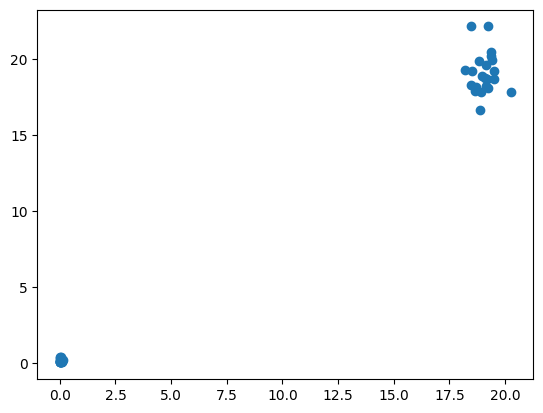

In [9]:
import matplotlib.pyplot as plt

plt.scatter(actual, pred)
plt.show()

In [ ]:
res = {
    'date': dates,
    'pred': pred,
    'actual': actual
}
res = pd.DataFrame.from_dict(res, orient='columns')
res['date'] = pd.to_datetime(res['date'], format='%Y-%m-%d %H:%M:%S')